In [1]:
import sys, os, copy, re, time
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
%matplotlib inline

# Input files

In [2]:
# Input files:
vessel_id_fnam = 'input/seahawks_vessel-ids.txt'     # Vessel data from "View" tab (use copy to clipboard and paste in notepad)
device_log_fnam = 'input/seahawks_device-log.txt'    # Log from "Status" tab, exported to tab separated text file

# Input processing

In [3]:
# Read vessel info
vessel_df = pd.read_csv(vessel_id_fnam, sep='\t')
vessel_df = vessel_df.loc[:, ['Vessel Name', 'Owner', 'Last Scan', 'Scan Type', 'Vessel ID']]

In [4]:
# Connect vessel ID to owner:
vessel2owner = dict()
for i, o in zip(vessel_df['Vessel ID'].values, vessel_df['Owner'].values):
    try:
        i = int(i)
        assert(i not in vessel2owner)
        vessel2owner[i] = o
    except:  # weed out the few mis-annotations (probable deleted users)
        # print(i, o)
        pass

In [5]:
# Read log and process into a dataframe of all scans:
scan_list = list()  # list for all the scans
for line in reversed(list(open(device_log_fnam))): # Reserved order, to encounter scan start first then scan finish
    line = line.rstrip()
    if ' Scan started [' in line:
        cols = line.split(' Scan started ')
        time_start_str = cols[0]
        time_start = time.strptime(time_start_str, "%m/%d/%Y %I:%M:%S %p")
        b = cols[1].index(': ')
        e = cols[1].index(']')
        vessel_ids = tuple([int(vid) for vid in cols[1][b+2:e].split(',')])
        # Handle deleted users:
        for vid in vessel_ids:
            if vid not in vessel2owner:
                vessel2owner[vid] = 'Deleted User'

        owners = tuple([vessel2owner[vid] for vid in vessel_ids])
        # The fraction of scan time per vessel is taken to be
        # the equal for all vessels in the scan group:
        owner_fracs = tuple([1.0 / len(vessel_ids)] * len(vessel_ids))
    elif ' Scan complete.' in line:
        cols = line.split(' Scan complete.')
        time_end_str = cols[0]
        time_end = time.strptime(time_end_str, "%m/%d/%Y %I:%M:%S %p")
        time_spent = time.mktime(time_end) - time.mktime(time_start)
        try:
            assert(time_spent < 60*60*24)
        except:
            raise Exception('Scan took found to take {} days. Check if something is wrong.'.format(time_spent/(60*60*24)))
        # Break scans into vessels. Store in list with order:
        # ['Owner', 'Vessel ID', 'Scan start', 'Scan end', 'Scan start epoch', 'Scan end epoch', 'Scan time', 'Scan fraction']
        for i, vid in enumerate(vessel_ids):
            scan = [owners[i], vid, time_start_str, time_end_str, time.mktime(time_start), time.mktime(time_end), time_spent, owner_fracs[i]]
            scan_list.append(scan)

# Generate the scan dataframe and calculate the time per vessel:
scan_data = pd.DataFrame(scan_list, columns=['Owner', 'Vessel ID', 'Scan start', 'Scan end', 'Scan start epoch', 'Scan end epoch', 'Scan time', 'Scan fraction'])
scan_data['Scan time X fraction'] = scan_data['Scan time'] * scan_data['Scan fraction']
scan_data.to_excel('output_excel/scan_data.xlsx')

In [6]:
scan_data

,Owner,Vessel ID,Scan start,Scan end,Scan start epoch,Scan end epoch,Scan time,Scan fraction,Scan time X fraction
0,Admin,7,8/19/2019 12:49:09 PM,8/19/2019 12:50:06 PM,1.566244e+09,1.566244e+09,57.0,1.0,57.0
1,Admin,5,8/19/2019 1:45:00 PM,8/19/2019 2:04:44 PM,1.566248e+09,1.566249e+09,1184.0,1.0,1184.0
2,Admin,5,8/19/2019 2:30:00 PM,8/19/2019 2:48:35 PM,1.566250e+09,1.566251e+09,1115.0,1.0,1115.0
3,Admin,5,8/19/2019 3:15:00 PM,8/19/2019 3:34:09 PM,1.566253e+09,1.566254e+09,1149.0,1.0,1149.0
4,Admin,5,8/19/2019 4:00:01 PM,8/19/2019 4:18:39 PM,1.566256e+09,1.566257e+09,1118.0,1.0,1118.0
...,...,...,...,...,...,...,...,...,...
29875,kdavidse,806,2/4/2022 9:00:00 AM,2/4/2022 9:09:22 AM,1.643994e+09,1.643995e+09,562.0,1.0,562.0
29876,kdavidse,808,2/4/2022 9:24:02 AM,2/4/2022 9:39:15 AM,1.643995e+09,1.643996e+09,913.0,1.0,913.0
29877,dalmiron,813,2/4/2022 9:57:02 AM,2/4/2022 10:12:16 AM,1.643997e+09,1.643998e+09,914.0,1.0,914.0
29878,dalmiron,814,2/4/2022 10:17:01 AM,2/4/2022 10:24:44 AM,1.643999e+09,1.643999e+09,463.0,1.0,463.0


# Statistics

In [7]:
# First scan:
v_min = scan_data.groupby(['Owner', 'Vessel ID']).min().reset_index().loc[:, ['Owner', 'Vessel ID', 'Scan start epoch']]
# Last scan:
v_max = scan_data.groupby(['Owner', 'Vessel ID']).max().reset_index().loc[:, ['Owner', 'Vessel ID', 'Scan end epoch']]
# Sum of scan time:
v_time = scan_data.groupby(['Owner', 'Vessel ID']).sum().reset_index().loc[:, ['Owner', 'Vessel ID', 'Scan time X fraction']]
vessel_time = v_min.merge(v_max, on=['Owner', 'Vessel ID'])
vessel_time = vessel_time.merge(v_time, on=['Owner', 'Vessel ID'])
vessel_time['Reserved time'] = vessel_time['Scan end epoch'] - vessel_time['Scan start epoch']
vessel_time['Scan reserved fraction'] = vessel_time['Scan time X fraction'] / vessel_time['Reserved time'] * 100
vessel_time.to_excel('output_excel/vessel_time.xlsx')

In [8]:
vessel_time

,Owner,Vessel ID,Scan start epoch,Scan end epoch,Scan time X fraction,Reserved time,Scan reserved fraction
0,Admin,5,1.566248e+09,1.566508e+09,107396.0,260332.0,41.253476
1,Admin,7,1.566244e+09,1.566244e+09,57.0,57.0,100.000000
2,Admin,529,1.619654e+09,1.619713e+09,22442.0,58281.0,38.506546
3,Admin,530,1.619652e+09,1.619653e+09,174.0,174.0,100.000000
4,Deleted User,46,1.570644e+09,1.570644e+09,63.0,63.0,100.000000
...,...,...,...,...,...,...,...
716,zshire,73,1.572367e+09,1.573063e+09,43077.5,696137.0,6.188078
717,zshire,74,1.572367e+09,1.573063e+09,43077.5,696137.0,6.188078
718,zshire,75,1.572367e+09,1.573063e+09,43077.5,696137.0,6.188078
719,zshire,76,1.572367e+09,1.573063e+09,43077.5,696137.0,6.188078


### Utilization

In [9]:
print('First scan started on {}'.format(time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime(scan_data['Scan start epoch'].min()))))
print('Last scan finished on {}'.format(time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime(scan_data['Scan end epoch'].max()))))
print('Total number of scans: {}'.format(len(scan_data)))
print('Total number of vessels: {}'.format(len(vessel_time)))
total_time = scan_data['Scan end epoch'].max() - scan_data['Scan start epoch'].min()
total_scan_time = scan_data['Scan time X fraction'].sum()
print('Scan time as a percent of total lifetime: {} %'.format(round(total_scan_time / total_time * 100, 1)))

First scan started on Mon, 19 Aug 2019 12:49:09
Last scan finished on Fri, 04 Feb 2022 10:50:59
Total number of scans: 29880
Total number of vessels: 721
Scan time as a percent of total lifetime: 20.4 %


### User scan and reserved time

In [10]:
user_time = vessel_time.groupby(['Owner']).sum().reset_index().loc[:, ['Owner', 'Scan time X fraction', 'Reserved time']]
user_time['Scan reserved fraction'] = user_time['Scan time X fraction'] / user_time['Reserved time'] * 100
user_time.to_excel('output_excel/user_time.xlsx')

In [11]:
user_time

,Owner,Scan time X fraction,Reserved time,Scan reserved fraction
0,Admin,1.300690e+05,318844.0,40.793931
1,Deleted User,8.380000e+02,1807.0,46.375208
2,adiab,2.817000e+03,270107.0,1.042920
3,aidan,1.368000e+04,349270.0,3.916741
4,aloeb,2.135900e+04,249103.0,8.574365
5,amacy,3.184805e+05,4954805.0,6.427710
6,amihalas,1.246590e+05,268066.0,46.503100
7,athelen,1.998957e+06,16675352.0,11.987495
8,cjenkin2,4.833836e+05,5130919.0,9.420995
9,dalmiron,5.826470e+05,4635820.0,12.568370


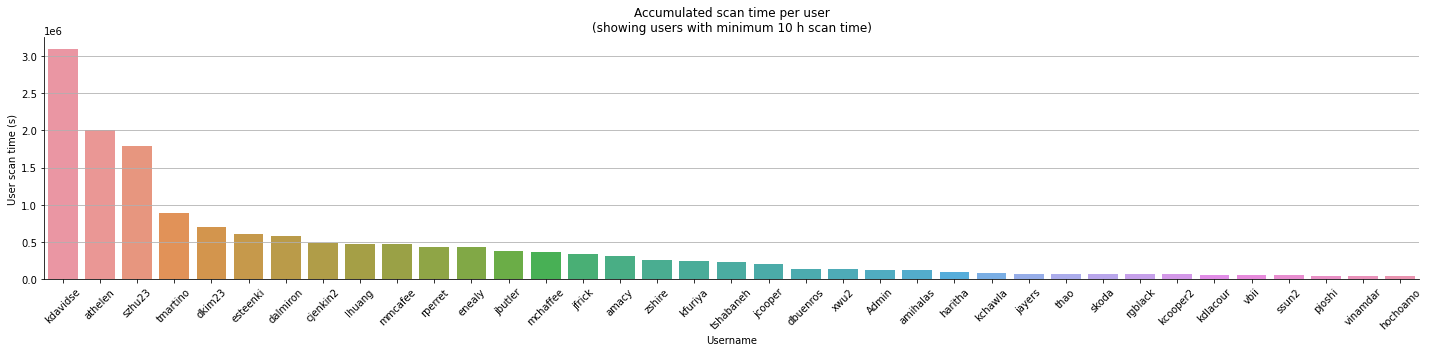

In [12]:
# Plot scan time:
fig, ax1 = plt.subplots(1, 1, figsize=(20, 5))
mask = (user_time['Scan time X fraction'] > 60*60*10)
g1 = sns.barplot(ax=ax1, data=user_time[mask], x='Owner', y='Scan time X fraction', alpha=1, zorder=1, order=user_time[mask].sort_values('Scan time X fraction', ascending=False)['Owner'].values)
g1.grid(True, axis='y')
g1.set_ylabel('User scan time (s)')
g1.set_xlabel('Username')
g1.set_title('Accumulated scan time per user\n(showing users with minimum 10 h scan time)')
for item in g1.get_xticklabels():
    item.set_rotation(45)
sns.despine()
fig.tight_layout()
fig.savefig('output_plots/acc-scan-user.pdf', bbox_inches='tight')

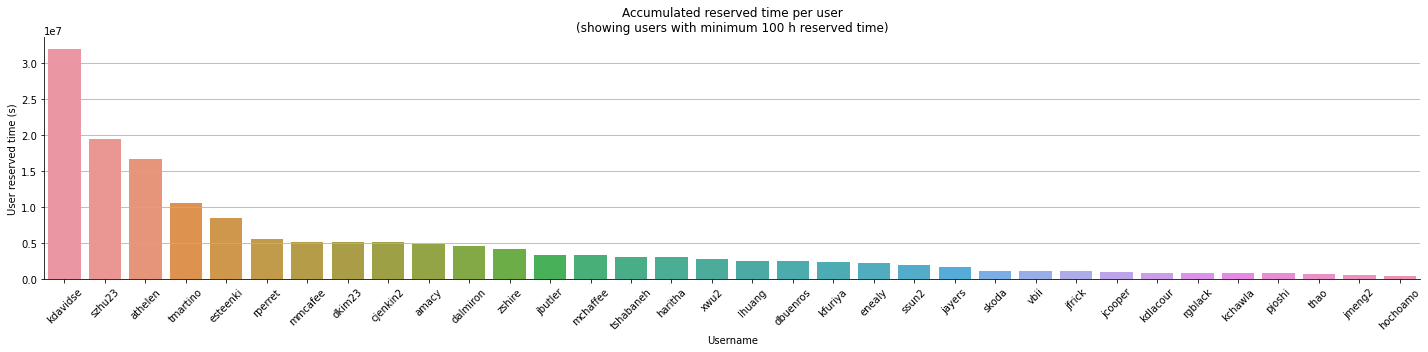

In [13]:
# Plot reserved time:
fig, ax1 = plt.subplots(1, 1, figsize=(20, 5))
mask = (user_time['Reserved time'] > 60*60*100)
g1 = sns.barplot(ax=ax1, data=user_time[mask], x='Owner', y='Reserved time', alpha=1, zorder=1, order=user_time[mask].sort_values('Reserved time', ascending=False)['Owner'].values)
g1.grid(True, axis='y')
g1.set_ylabel('User reserved time (s)')
g1.set_xlabel('Username')
g1.set_title('Accumulated reserved time per user\n(showing users with minimum 100 h reserved time)')
for item in g1.get_xticklabels():
    item.set_rotation(45)
sns.despine()
fig.tight_layout()
fig.savefig('output_plots/acc-resrv-user.pdf', bbox_inches='tight')